In [12]:
import os
import torch
import torch.utils
import torch.utils.data
from sklearn.datasets import make_sparse_coded_signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from contextlib import contextmanager
from timeit import default_timer
# from test_omp import omp_naive
# from test import *  # FIXME: better name


In [28]:
y_0, X_0, w_0 = make_sparse_coded_signal(
    n_samples=1,
    n_components=1000,
    n_features=96,
    n_nonzero_coefs=10,
    random_state=0)

requires_grad = True
y = torch.tensor(y_0, dtype=torch.float32, requires_grad=requires_grad).reshape(y_0.shape[0], -1).T.detach()
X = torch.tensor(X_0, dtype=torch.float32, requires_grad=requires_grad).reshape(1, X_0.shape[0], -1).detach()
w = torch.tensor(w_0, dtype=torch.float32, requires_grad=requires_grad).T.detach()
X.requires_grad = True
y.requires_grad = True
w.requires_grad = True

print('y', y.shape)
print('X', X.shape)
print('w', w.shape)
print('chunk_legth', y.shape[1])
print('n_atoms', X.shape[1])
print('n_nonzero_coefs', 10)
y.is_leaf, X.is_leaf, w.is_leaf
# y_hat = X @ w
# ((y_hat-y)**2).sum()

y torch.Size([1, 96])
X torch.Size([1, 96, 1000])
w torch.Size([1000])
chunk_legth 96
n_atoms 96
n_nonzero_coefs 10


(True, True, True)

In [50]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.datasets import make_regression

n_nonzero_coefs=10
y_, X_, w_ = make_sparse_coded_signal(
    n_samples=1,
    n_components=1000,
    n_features=96,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)

omp_ = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
reg = omp_.fit(X_, y_)
omp_.coef_[omp_.coef_ != 0][:15], w_[w_ != 0][:15]
# reg.score(X_0, y_0)

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/sklearn/datasets/_samples_generator.py:1335: FutureWarning: The default value of data_transposed will change from True to False in version 1.3
  warnings.warn(


(array([-0.77817141, -2.08033674, -2.27265899, -0.62209651,  1.55394908,
         1.43806502, -0.94548482, -0.48103745,  0.98482889, -0.71483167]),
 array([-0.77817141, -2.08033674, -2.27265899, -0.62209651,  1.55394908,
         1.43806502, -0.94548482, -0.48103745,  0.98482889, -0.71483167]))

In [29]:
torch.manual_seed(0)
dictionary_noise = (torch.rand_like(X.detach())*(X.std().detach()*.00000005))
X_hat = X.detach() + dictionary_noise
X_hat.requires_grad = True
dictionary_noise.norm()

tensor(9.1333e-07)

In [30]:
'''Orthogonal Matching pursuit algorithm
'''
# X_hat = X_hat/(X_hat.norm(dim=1, keepdim=True) + 1e-30)
# X_hat = X
dict = X_hat[0, ...] # consider cloning the tensor

chunk_length, n_atoms = dict.shape
batch_sz, chunk_length = y.shape
n_nonzero_coefs = 10
tau = 1e-3
hard = True
hard_mode = 0
reg_=1e-10

# DTD = dict.T @ dict

residuals = y.clone().detach() # (batch_sz, chunk_length)
residuals.requires_grad = True
# max_score_indices = y.new_zeros((batch_sz, n_nonzero_coefs, n_atoms), dtype=X.dtype, device=X.device)
max_score_indices = []
sum_collector = torch.zeros((batch_sz, n_atoms), dtype=X.dtype, device=X.device)
detached_indices = np.zeros((batch_sz, n_nonzero_coefs), dtype=np.int64) # (batch_sz, n_nonzero_coefs)


tolerance = True
# Control stop interation with norm thresh or sparsity
for i in range(n_nonzero_coefs):
    # Compute the score of each atoms
    projections = dict.T @ residuals[:, :, None] # (batch_sz, n_atoms, 1)

    detached_indices[:, i] = projections.abs().squeeze(-1).argmax(-1).detach().cpu().numpy()
    soft_score_indices = (projections/tau).abs().squeeze(-1).softmax(-1) # (batch_sz, n_atoms)
    
    if hard:
        # copied and modified from https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
        # Straight through.
        index = soft_score_indices.max(-1, keepdim=True)[1]
        hard_score_indices = torch.zeros_like(soft_score_indices).scatter_(-1, index, 1.0)
        ret = hard_score_indices - soft_score_indices.detach() + soft_score_indices   
        # max_score_indices[:, i] = ret
        if hard_mode == 0:
            max_score_indices.append(ret[:, None, :]) # (batch_sz, i+1, n_atoms), it is list on dimension of i+1
            
            # update selected_D torch.cat(max_score_indices, dim=1)
            ## first indexing then multiplication with max_score_indices
            ind_0 = torch.arange(batch_sz)[:, None, None]
            ind_1 = torch.arange(chunk_length)[None, :, None]
            _selected_D = X_hat[ind_0, ind_1, detached_indices[:, None, :i+1]] # (batch_sz, chunk_length, i+1)
            ind_0 = torch.arange(batch_sz)[:, None]
            ind_1 = torch.arange(i+1)[None, :]
            _selected_max_score_indices = torch.cat(max_score_indices, dim=1)[ind_0, ind_1, detached_indices[:, :i+1]]
            selected_D = _selected_D * _selected_max_score_indices[:, None, :] # (batch_sz, chunk_length, i+1)
            ## first multiplication then indexing with max_score_indices 
            # _selected_D = X[:, None, ...] * torch.cat(max_score_indices, dim=1)[:, :i+1, None, :] # max_score_indices[:, :i+1, None, :] # (batch_sz, i+1, chunk_length, n_atoms)
            # _selected_D = _selected_D.permute(0, 2, 1, 3) # (batch_sz, chunk_length, i+1, n_atoms)
            # ind_0 = torch.arange(batch_sz)[:, None, None]
            # ind_1 = torch.arange(chunk_length)[None, :, None]
            # ind_2 = torch.arange(i+1)[None, None, :]
            # selected_D = _selected_D[ind_0, ind_1, ind_2, detached_indices[:, None, :i+1]] # (batch_sz, chunk_length, i+1)
            
            # calculate selected_DTy
            selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, i+1, 1)

            # calculate selected_DTD
            selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, i+1, i+1)

            # find W = (selected_DTD)^-1 @ selected_DTy
            selected_DTD.diagonal(dim1=-2, dim2=-1).add_(reg_) # TODO: add multipath OMP
            nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, i+1, 1)

            # finally get residuals r=y-Wx
            residuals = y - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length)
        else:
            sum_collector = sum_collector + ret
            selected_D = X_hat * sum_collector[:, None, :] # (batch_sz, chunk_length, n_atoms)
            
            # calculate selected_DTy
            selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, n_atoms, 1)

            # calculate selected_DTD
            selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, n_atoms, n_atoms)

            # find W = (selected_DTD)^-1 @ selected_DTy
            selected_DTD.diagonal(dim1=-2, dim2=-1).add_(reg_) # TODO: add multipath OMP
            nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, n_atoms, 1)

            # finally get residuals r=y-Wx
            residuals = y - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length)
            
            
    else:
        # raise NotImplementedError
        sum_collector = sum_collector + soft_score_indices
        selected_D = X_hat * sum_collector[:, None, :] # (batch_sz, chunk_length, n_atoms)
        
        # calculate selected_DTy
        selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, n_atoms, 1)

        # calculate selected_DTD
        selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, n_atoms, n_atoms)

        # find W = (selected_DTD)^-1 @ selected_DTy
        selected_DTD.diagonal(dim1=-2, dim2=-1).add_(reg_) # TODO: add multipath OMP
        nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, n_atoms, 1)

        # finally get residuals r=y-Wx
        residuals = y - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length)

if hard:
    if hard_mode == 0:
        W = torch.zeros(batch_sz, n_atoms, dtype=selected_D.dtype, device=selected_D.device)
        W[torch.arange(batch_sz)[:, None], detached_indices] = nonzero_W.squeeze(-1)
    else:
        W = nonzero_W.squeeze(-1)
else:
    W = nonzero_W.squeeze(-1)


In [31]:
y_hat = X_hat @ W[..., None]
loss = ((y_hat.squeeze(-1)-y)).norm()
loss
loss.backward(), loss, detached_indices[0,:10], X.grad, X_hat.grad[0, :, 78][:10], X_hat.grad[0, :, 230][:10], X_hat.grad.abs().sum(), X_hat.grad[0, :, 78].abs().sum(), X_hat.grad[0, :, 230].abs().sum()

(None,
 tensor(5.2642e-07, grad_fn=<LinalgVectorNormBackward0>),
 array([183, 466, 559, 587, 934, 636, 474, 155, 973, 855]),
 None,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor(1361.9825),
 tensor(0.),
 tensor(0.))

In [32]:
print('omp non zero weights', W[W!=0][:10])
print('scikit learn weights', w[w!=0][:10])

omp non zero weights tensor([-0.7782, -2.0803, -2.2727, -0.6221,  1.5539,  1.4381, -0.9455, -0.4810,
         0.9848, -0.7148], grad_fn=<SliceBackward0>)
scikit learn weights tensor([-0.7782, -2.0803, -2.2727, -0.6221,  1.5539,  1.4381, -0.9455, -0.4810,
         0.9848, -0.7148], grad_fn=<SliceBackward0>)


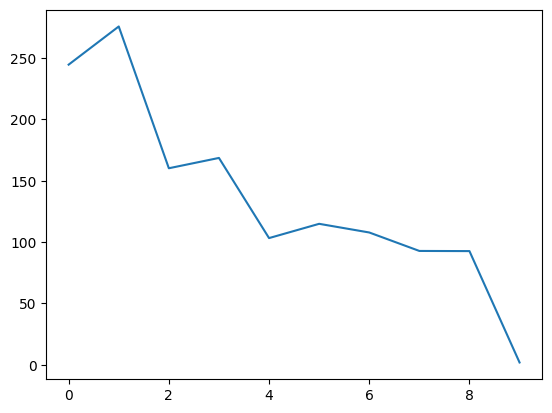

In [33]:
abs_sums = []
for i in range(len(detached_indices[0])):
    abs_sums.append(X_hat.grad[0, :, detached_indices[0, i]].abs().sum())
plt.plot(abs_sums)

In [5]:
# fake_loss = W.sum() + 100
fake_loss = (nonzero_W**5).sum() + 100
fake_loss.backward()

In [ ]:
X.grad, y.grad, w.grad, X.is_leaf, soft_score_indices.requires_grad

# Alex idea for OMP

In [75]:
n_components = 60
y_0, X_0, w_0 = make_sparse_coded_signal(
    n_samples=1,
    n_components=1000,
    n_features=672,
    n_nonzero_coefs=n_components,
    random_state=0)

requires_grad = True
y = torch.tensor(y_0, dtype=torch.float32, requires_grad=requires_grad).reshape(y_0.shape[0], -1).T.detach()
X = torch.tensor(X_0, dtype=torch.float32, requires_grad=requires_grad).reshape(1, X_0.shape[0], -1).detach()
w = torch.tensor(w_0, dtype=torch.float32, requires_grad=requires_grad).T.detach()
X.requires_grad = True
y.requires_grad = True
w.requires_grad = True

y.shape, X.shape, w.shape, y.is_leaf, X.is_leaf, w.is_leaf
# y_hat = X @ w
# ((y_hat-y)**2).sum()

(torch.Size([1, 672]),
 torch.Size([1, 672, 1000]),
 torch.Size([1000]),
 True,
 True,
 True)

In [76]:
torch.manual_seed(0)
dictionary_noise = (torch.rand_like(X.detach())*(X.std().detach()*.0009))
X_hat = X.detach() + dictionary_noise
X_hat.requires_grad = True
dictionary_noise.norm()

tensor(0.0164)

In [77]:
'''Orthogonal Matching pursuit algorithm
'''
# X_hat = X_hat/(X_hat.norm(dim=1, keepdim=True) + 1e-30)
X_hat = X
dict = X_hat[0, ...] # consider cloning the tensor


chunk_length, n_atoms = dict.shape
batch_sz, chunk_length = y.shape
n_nonzero_coefs = n_components
tau = 1e-3
hard = True
reg_ = 1e-15

# DTD = dict.T @ dict

residuals = y.clone().detach() # (batch_sz, chunk_length)
residuals.requires_grad = True

max_score_indices = []
detached_indices = np.zeros((batch_sz, n_nonzero_coefs), dtype=np.int64) # (batch_sz, n_nonzero_coefs)
# max_score_indices = y.new_zeros((batch_sz, n_nonzero_coefs, n_atoms), dtype=X.dtype, device=X.device)
# sum_collector = torch.zeros((batch_sz, n_atoms), dtype=X.dtype, device=X.device)

intermediate_gradients = []

tolerance = True
# Control stop interation with norm thresh or sparsity
for i in range(n_nonzero_coefs):
    # Compute the score of each atoms
    projections = dict.T @ residuals[:, :, None] # (batch_sz, n_atoms, 1)
    soft_score_indices = (projections/tau).abs().squeeze(-1).softmax(-1) # (batch_sz, n_atoms)
    detached_indices[:, i] = projections.abs().squeeze(-1).argmax(-1).detach().cpu().numpy() # (batch_sz, ) for final W

    if hard:
        # copied and modified from https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
        # Straight through.
        index = soft_score_indices.max(-1, keepdim=True)[1]
        hard_score_indices = torch.zeros_like(soft_score_indices).scatter_(-1, index, 1.0)
        ret = hard_score_indices - soft_score_indices.detach() + soft_score_indices # (batch_sz, n_atoms)  

        max_score_indices.append(ret[:, :, None]) # list[(batch_sz, n_atoms)] * i+1
        
        z = torch.cat(max_score_indices, dim=2) # (batch_sz, n_atoms, i+1)
        z.register_hook(lambda grad: intermediate_gradients.append(grad))
        
        # update selected_D
        selected_D = X_hat @ z # (batch_sz, chunk_length, i+1)
        
        # calculate selected_DTy
        selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, i+1, 1)

        # calculate selected_DTD
        selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, i+1, i+1)

        # find W = (selected_DTD)^-1 @ selected_DTy
        selected_DTD.diagonal(dim1=-2, dim2=-1).add_(reg_) # TODO: add multipath OMP
        # print(i)
        nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, i+1, 1)

        # finally get residuals r=y-Wx
        residuals = y.detach() - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length)                    
            
    else:
        max_score_indices.append(soft_score_indices[:, :, None]) # list[(batch_sz, n_atoms)] * i+1
        
        # update selected_D
        selected_D = X_hat @ torch.cat(max_score_indices, dim=2) # (batch_sz, chunk_length, i+1)
        
        # calculate selected_DTy
        selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, i+1, 1)

        # calculate selected_DTD
        selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, i+1, i+1)

        # find W = (selected_DTD)^-1 @ selected_DTy
        # selected_DTD.diagonal(dim1=-2, dim2=-1).add_(reg_) # TODO: add multipath OMP
        
        nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, i+1, 1)

        # finally get residuals r=y-Wx
        residuals = y.detach() - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length)        


W = torch.zeros(batch_sz, n_atoms, dtype=selected_D.dtype, device=selected_D.device,)
W[torch.arange(batch_sz)[:, None], detached_indices] = nonzero_W.squeeze(-1)
# aaa=5

In [78]:
y_hat = X_hat @ W[..., None]
loss = ((y_hat.squeeze(-1)-y)).norm()
loss
loss.backward(), loss, X_hat.grad.abs().sum(), detached_indices[0,:10], X.grad, 

(None,
 tensor(3.8710e-06, grad_fn=<LinalgVectorNormBackward0>),
 tensor(6832.4595),
 array([134, 671, 932, 571, 717, 300, 765, 295, 730, 245]),
 tensor([[[-1.1049e-09, -1.7447e-08,  2.2288e-08,  ..., -4.4559e-09,
            1.2685e-08,  1.2868e-08],
          [ 5.5595e-10,  8.7786e-09, -1.1215e-08,  ...,  2.2421e-09,
           -6.3827e-09, -6.4746e-09],
          [ 5.5591e-09,  8.7780e-08, -1.1214e-07,  ...,  2.2419e-08,
           -6.3822e-08, -6.4742e-08],
          ...,
          [-2.0068e-09, -3.1688e-08,  4.0481e-08,  ..., -8.0931e-09,
            2.3039e-08,  2.3371e-08],
          [ 2.1093e-09,  3.3306e-08, -4.2549e-08,  ...,  8.5064e-09,
           -2.4216e-08, -2.4565e-08],
          [-6.5492e-10, -1.0341e-08,  1.3211e-08,  ..., -2.6412e-09,
            7.5188e-09,  7.6270e-09]]]))

In [73]:
intermediate_gradients[8]

tensor([[[ 0.0152,  0.0186, -0.0106,  ..., -0.0079, -0.0037,  0.0060],
         [ 0.0608,  0.0693, -0.0417,  ..., -0.0336, -0.0235,  0.0259],
         [-0.0128, -0.0130,  0.0086,  ...,  0.0077,  0.0078, -0.0060],
         ...,
         [-0.0920, -0.1053,  0.0632,  ...,  0.0507,  0.0349, -0.0391],
         [-0.0546, -0.0606,  0.0373,  ...,  0.0309,  0.0241, -0.0239],
         [ 0.0532,  0.0628, -0.0368,  ..., -0.0285, -0.0169,  0.0219]]])

In [74]:
X_hat.grad[0, :, 78][:10], X_hat.grad[0, :, 230][:10], X_hat.grad[0, :, 78].abs().sum(), X_hat.grad[0, :, 230].abs().sum()

(tensor([-6.6665e-05,  1.2459e-05,  2.7092e-05, -1.2592e-04, -6.9761e-06,
         -5.7957e-05, -2.6137e-05, -7.8092e-05,  1.2452e-04, -1.4746e-04]),
 tensor([ 2.1592e-05,  8.1322e-04,  3.7637e-04, -1.1535e-03,  1.8990e-04,
         -4.2887e-04,  1.0303e-03,  2.4815e-04,  5.2009e-04,  5.6881e-04]),
 tensor(0.0082),
 tensor(0.0360))

In [79]:
print('omp non zero weights', W[W!=0][:10])
print('scikit learn weights', w[w!=0][:10])

omp non zero weights tensor([-0.4428,  0.4637,  1.1912,  1.1665,  1.3531, -1.3745, -2.6326, -0.4378,
         0.2723,  0.5249], grad_fn=<SliceBackward0>)
scikit learn weights tensor([-0.4428,  0.4637,  1.1912,  1.1665,  1.3531, -1.3745, -2.6326, -0.4378,
         0.2723,  0.5249], grad_fn=<SliceBackward0>)


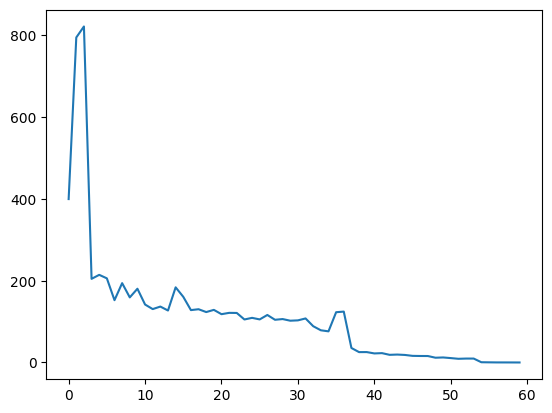

In [80]:
abs_sums = []
for i in range(len(detached_indices[0])):
    abs_sums.append(X_hat.grad[0, :, detached_indices[0, i]].abs().sum())
plt.plot(abs_sums[:])

In [115]:
# fake_loss = W.sum() + 100
fake_loss = (nonzero_W**1).sum() + 0
fake_loss.backward()

In [ ]:
X.grad[0, :, 78], detached_indices,X.grad.abs().sum()

In [2]:
import torch
x = torch.tensor(2.0, requires_grad = True)
print("x:", x)
y = x**2
y.backward()
x.grad
y.is_leaf, x.is_leaf, x.grad.is_leaf

x: tensor(2., requires_grad=True)


(False, True, True)

In [670]:
w[w!=0]

tensor([-1.5408,  1.2117,  1.3392, -0.2476,  0.8874, -0.9175,  0.4356,  0.6046,
        -2.0075, -0.3002, -0.5613,  1.1176,  1.4062, -0.0574,  0.1614, -0.6855,
         0.2678,  0.8091, -0.9437, -1.0636, -1.8954,  0.7429, -0.0113, -0.7047,
         1.5529,  0.7159,  0.2365,  0.0320,  0.6710, -0.2902,  1.4943,  1.2897,
        -0.8026, -1.0412, -0.2379, -0.4289,  0.3764, -1.0462, -1.1264,  0.4701,
         1.4027, -0.2258,  0.0994, -0.0367,  0.2440,  1.1910,  0.3706,  0.5264,
         1.4489, -0.4281,  0.3012,  1.2043, -0.5630,  1.0285, -0.2981, -1.8573,
        -1.2280, -1.0510, -0.8269, -1.0729,  0.1356,  0.7133,  0.0422,  1.2057,
         1.5344, -1.3419, -0.0380,  0.7402, -1.3527, -0.2217,  2.4217, -0.6209,
        -0.2137,  0.3353,  0.1102, -0.6201, -1.6132,  0.1191,  0.1394, -0.0561,
        -0.4938,  2.1766, -1.3532,  0.2044, -1.6174, -0.8904,  1.3027,  0.7292,
         0.3150,  1.3376,  0.1009,  0.5461, -2.3974,  1.6264, -0.1896, -0.7224,
        -0.7440,  0.9898, -0.4637, -0.39

In [19]:
torch.cat(max_score_indices, dim=1)[0, :][torch.cat(max_score_indices, dim=1)[0, :]!=0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<IndexBackward0>)

In [669]:
W[W!=0]

tensor([ 0.3781,  0.5507,  0.0411,  0.4116, -0.3544, -0.3975,  0.3310, -0.5897,
         0.5411,  0.4769, -0.1108,  0.6286, -0.5244,  0.0532, -0.6963, -0.4543,
        -0.5881, -0.2190,  0.0703, -0.4413,  0.3593,  0.2277, -0.4663, -0.5157,
         0.0351,  0.0877, -0.1503, -0.5425,  0.0225,  0.1120, -0.4264,  0.5205,
        -0.4977,  0.3502, -0.0114, -0.3009,  0.2730,  0.0585,  0.5792,  0.1418,
        -0.2939,  0.3730, -0.2957,  0.3881, -0.1518,  0.5543, -0.0378,  0.0041,
        -0.3575,  0.2728, -0.1623, -0.3832, -0.5734, -0.5295, -0.1485, -0.0939,
        -0.2373,  0.4941, -0.3694,  0.6005, -0.5624, -0.3042,  0.4301,  0.3673,
        -0.4097, -0.4645,  0.2106,  0.5288, -0.4540, -0.4228, -0.4433,  0.2331,
        -0.4318, -0.4201,  0.1485, -0.6147,  0.5219,  0.1050,  0.4204, -0.1920,
        -0.1441,  0.4040,  0.4054,  0.4164, -0.7370, -0.4144,  0.0559, -0.1843,
        -0.4349, -0.0398,  0.4193,  0.5104, -0.1027,  0.4634, -0.2689, -0.3532,
         0.0082, -0.4478,  0.0118,  0.47

### grid_sample differentiable

In [6]:
import torch
import torch.nn.functional as F
src = torch.arange(25, dtype=torch.float).reshape(1, 1, 5, 5).requires_grad_()  # 1 x 1 x 6 x 5 with 0 ... 30
indices = torch.tensor([[-1, 0],[1, 1]], dtype=torch.float).reshape(1, 1, -1, 2)  # 1 x 1 x 2 x 2
output = F.grid_sample(src, indices)
print(output, output.shape)  # tensor([[[[  0.,  12.]]]])

tensor([[[[5., 6.]]]], grad_fn=<GridSampler2DBackward0>) torch.Size([1, 1, 1, 2])


In [77]:
src

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]], requires_grad=True)

In [75]:
indices

tensor([[[[0.0000, 0.5000]]]])

In [45]:
import torch
from torch.autograd import Variable

torch.manual_seed(0)
x = Variable(torch.arange(9, dtype=torch.float).reshape(-1,3), requires_grad=True)
idx = Variable(torch.FloatTensor([0,1]), requires_grad=True)


i0 = idx.floor().detach()
i1 = i0 + 1
i_1 = i0 - 1

y0 = x[i0.long(), :]
y1 = x[i1.long(), :]
y_1 = x[i_1.long(), :]

Wa = (i1 - idx).unsqueeze(1).expand_as(y0)
Wb = (idx - i0).unsqueeze(1).expand_as(y1)
Wa2 = (idx - i_1).unsqueeze(1).expand_as(y_1)
Wb2 = (i0 - idx).unsqueeze(1).expand_as(y_1)

out = (Wa * y0 + Wb * y1 + Wa2 * y0 + Wb2 * y_1)/2

print(out)
out.sum().backward()
print(idx.grad)

tensor([[0., 1., 2.],
        [3., 4., 5.]], grad_fn=<DivBackward0>)
tensor([-4.5000,  9.0000])


In [46]:
y0, y1
Wa2, Wb2

(tensor([[1., 1., 1.],
         [1., 1., 1.]], grad_fn=<ExpandBackward0>),
 tensor([[0., 0., 0.],
         [0., 0., 0.]], grad_fn=<ExpandBackward0>))

In [48]:
y_1

tensor([[6., 7., 8.],
        [0., 1., 2.]], grad_fn=<IndexBackward0>)

In [49]:
x

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], requires_grad=True)

In [78]:
xx = x.reshape(1,1,3,3)
xx

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], grad_fn=<ReshapeAliasBackward0>)

In [81]:

grid = torch.tensor([0, -1.]).reshape(1,1,1,2).float()
F.grid_sample(xx, grid)

/home/mahdigilany/anaconda3/envs/borealis/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[[[0.5000]]]], grad_fn=<GridSampler2DBackward0>)

In [124]:
input = torch.arange(5*5).view(1, 1, 5, 5).float()
print(input)

# Create grid to upsample input
d = torch.linspace(-1, 1, 10)
meshx, meshy = torch.meshgrid((d, d))
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0) # add batch dim

output = torch.nn.functional.grid_sample(input, grid, align_corners=True)
print(output)

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]])
tensor([[[[ 0.0000,  0.4444,  0.8889,  1.3333,  1.7778,  2.2222,  2.6667,
            3.1111,  3.5556,  4.0000],
          [ 2.2222,  2.6667,  3.1111,  3.5556,  4.0000,  4.4444,  4.8889,
            5.3333,  5.7778,  6.2222],
          [ 4.4444,  4.8889,  5.3333,  5.7778,  6.2222,  6.6667,  7.1111,
            7.5556,  8.0000,  8.4444],
          [ 6.6667,  7.1111,  7.5556,  8.0000,  8.4444,  8.8889,  9.3333,
            9.7778, 10.2222, 10.6667],
          [ 8.8889,  9.3333,  9.7778, 10.2222, 10.6667, 11.1111, 11.5556,
           12.0000, 12.4444, 12.8889],
          [11.1111, 11.5556, 12.0000, 12.4444, 12.8889, 13.3333, 13.7778,
           14.2222, 14.6667, 15.1111],
          [13.3333, 13.7778, 14.2222, 14.6667, 15.1111, 15.5556, 16.0000,
           16.4444, 16.8889, 17.3333],
          [15.5556, 1

In [130]:
input.reshape(1,5,1,5)[0,0,...]

tensor([[0., 1., 2., 3., 4.]])

In [136]:
grid = torch.tensor([-1, 0]).reshape(1,1,1,2).float()
F.grid_sample(input.reshape(1,5,1,5), grid, align_corners=True).shape

torch.Size([1, 5, 1, 1])

In [ ]:
'''Orthogonal Matching pursuit algorithm
'''
dict = X_hat[0, ...] # consider cloning the tensor

chunk_length, n_atoms = dict.shape
batch_sz, chunk_length = y.shape
n_nonzero_coefs = 15
tau = 1e-3
hard = True

# DTD = dict.T @ dict

residuals = y.clone().detach() # (batch_sz, chunk_length)
residuals.requires_grad = True
# max_score_indices = y.new_zeros((batch_sz, n_nonzero_coefs, n_atoms), dtype=X.dtype, device=X.device)
max_score_indices = []
detached_indices = np.zeros((batch_sz, n_nonzero_coefs), dtype=np.int64) # (batch_sz, n_nonzero_coefs)


tolerance = True
# Control stop interation with norm thresh or sparsity
for i in range(n_nonzero_coefs): 
    # Compute the score of each atoms
    projections = dict.T @ residuals[:, :, None] # (batch_sz, n_atoms, 1)

    detached_indices[:, i] = projections.abs().squeeze(-1).argmax(-1).detach().cpu().numpy()
    soft_score_indices = (projections/tau).abs().squeeze(-1).softmax(-1) # (batch_sz, n_atoms)
    if hard:
        # copied and modified from https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
        # Straight through.
        index = soft_score_indices.max(-1, keepdim=True)[1]
        hard_score_indices = torch.zeros_like(soft_score_indices).scatter_(-1, index, 1.0)
        ret = hard_score_indices - soft_score_indices.detach() + soft_score_indices   
        # max_score_indices[:, i] = ret
        max_score_indices.append(ret[:, None, :])
    else:
        max_score_indices.append(soft_score_indices[:, None, :])
    
    # update selected_D torch.cat(max_score_indices, dim=1)
    _selected_D = X_hat[:, None, ...] * torch.cat(max_score_indices, dim=1)[:, :i+1, None, :] # max_score_indices[:, :i+1, None, :] # (batch_sz, i+1, chunk_length, n_atoms)
    _selected_D = _selected_D.permute(0, 2, 1, 3) # (batch_sz, chunk_length, i+1, n_atoms)
    ind_0 = torch.arange(batch_sz)[:, None, None]
    ind_1 = torch.arange(chunk_length)[None, :, None]
    ind_2 = torch.arange(i+1)[None, None, :]
    selected_D = _selected_D[ind_0, ind_1, ind_2, detached_indices[:, None, :i+1]] # (batch_sz, chunk_length, i+1)
    
    # s_D = dict[torch.arange(chunk_length)[:, None], detached_indices[:, :i+1]] # (chunk_length, i+1)

    # calculate selected_DTy
    selected_DTy = selected_D.permute(0, 2, 1) @ y[:, :, None] # (batch_sz, i+1, 1)

    # calculate selected_DTD
    selected_DTD = selected_D.permute(0, 2, 1) @ selected_D # (batch_sz, i+1, i+1)

    # find W = (selected_DTD)^-1 @ selected_DTy
    # selected_DTD.diagonal(dim1=-2, dim2=-1).add_(1.) # TODO: add multipath OMP
    nonzero_W = torch.linalg.solve(selected_DTD, selected_DTy) # (batch_sz, i+1, 1)

    # finally get residuals r=y-Wx
    residuals = y.detach() - (selected_D @ nonzero_W).squeeze(-1) # (batch_sz, chunk_length, 1)

W = torch.zeros(batch_sz, n_atoms, dtype=selected_D.dtype, device=selected_D.device)
W[torch.arange(batch_sz)[:, None], detached_indices] = nonzero_W.squeeze(-1)    
